## Python Code for Question 1

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
class Clean:

    '''
    Creating the Clean class which will be used to assess to assess the data
    and prepare analysis datasets.
    '''

    def __init__(self):
        self.path_basic = os.getcwd() + os.sep + os.sep.join(['csv' , 'cp4.csv'])

    def get_df_basic(self):
        '''
        Takes a csv file and creates a dataframe with entry ID (id) as the index
        This dataframe contains the raw data from our SQL query
        '''
        with open(self.path_basic) as file:
            df = pd.read_csv(file, index_col='id', sep=',', infer_datetime_format=True)
        df_basic = df
        return df_basic

    @staticmethod
    def categorize(lst, df):
        dct_lst = []
        for item in lst:
            codes, uniques = pd.factorize(df[item], sort=True)
            df[item] = codes + 1
            dct = dict(enumerate(uniques, 1))
            #dct[-1] = None
            dct_lst.append(dct)
            df[item] = df[item].replace(0, np.NaN)
        return df, dct_lst

In [3]:
# Working from the demographic class to get background information on the cohort
cl = Clean()
df = cl.get_df_basic()

#print(df.columns) # seeing what the column headers are for equations below
#print(df.describe())

# Creating a list of column headers
lst = ['lighting_condition', 'indoor_or_outdoor', 'weather_condition',
       'officer_in_uniform', 'officer_injured', 'officer_rank',
       'subject_armed', 'subject_age', 'subject_gender', 'subject_race',
       'officer_id', 'officer_gender', 'officer_race', 'officer_age',
       'wep_taser', 'wep_chemical', 'wep_other', 'wep_member', 'wep_phys',
       'wep_verb', 'wep_firearm', 'district_name', 'injury']

# Creating a list categorical column headers
cat_lst = ['lighting_condition', 'indoor_or_outdoor', 'weather_condition',
           'officer_in_uniform', 'officer_injured', 'officer_rank',
           'subject_armed', 'subject_gender', 'subject_race',
           'officer_id', 'officer_gender', 'officer_race', 'district_name']

# Dropping officer ID from dataframe
df.pop('officer_id')

# now use df_imp to create One Hot dummy variables
df_analysis = pd.get_dummies(df, drop_first=True)
for column in df.columns:
    df_analysis.loc[df[column].isnull(), df_analysis.columns.str.startswith(f'{column}_')] = np.nan
df_analysis = df_analysis.astype('float64')

# Imputing Missing Variables
imp = IterativeImputer(random_state=42, tol=0.01, min_value=0, max_value=1)
imputed_array = imp.fit_transform(df_analysis)
df_final = pd.DataFrame(data = imputed_array, columns = df_analysis.columns)
df_targets = df_final.pop('injury')

In [4]:
# Setup Training Data Set
X_train_full, X_test, y_train_full, y_test = train_test_split(df_final, df_targets, test_size=0.20, random_state=42)

# Create Validation and Training Sets
X_train, X_validate, y_train, y_validate = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

## Random Forest Model

In [5]:
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=25)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_validate)
y_pred_prob = rfc.predict_proba(X_validate)[:,1]

In [6]:
# Printing Classification Report
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_validate, y_pred_prob)
youden_values = list(tpr - fpr)
youden_index = youden_values.index(max(youden_values))
optimal_threshold = thresholds[youden_index]
trans = np.vectorize(lambda x: 1 if x > optimal_threshold else 0)
y_pred =  trans(y_pred_prob)

print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.67      0.72      9297
         1.0       0.44      0.58      0.50      4107

    accuracy                           0.64     13404
   macro avg       0.61      0.63      0.61     13404
weighted avg       0.68      0.64      0.65     13404



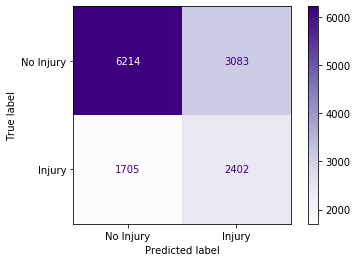

In [7]:
# Printing Confusion Matrix
cm = confusion_matrix(y_validate, y_pred)
target_names = ['No Injury', 'Injury']
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp = disp.plot(cmap='Purples', values_format='.0f')
plt.show()

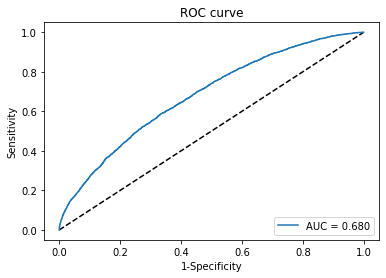

In [8]:
# Plotting ROC
fpr, tpr, thresholds = roc_curve(y_validate, y_pred_prob)
auc = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc='lower right')
# plt.savefig('/deepcovidxr/Ramsey_Keras/Resnet.pdf')
plt.show()

## KNN Model

In [9]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_validate)

In [10]:
# Printing Classification Report
print(classification_report(y_validate, knn_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.71      0.71      9297
         1.0       0.36      0.36      0.36      4107

    accuracy                           0.60     13404
   macro avg       0.54      0.54      0.54     13404
weighted avg       0.61      0.60      0.61     13404



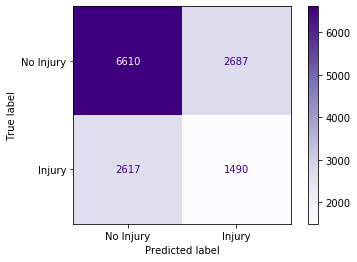

In [11]:
# Printing Confusion Matrix
cm = confusion_matrix(y_validate, knn_pred)
target_names = ['No Injury', 'Injury']
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp = disp.plot(cmap='Purples', values_format='.0f')
plt.show()

## Logistic Regression Model

In [12]:
lr = LogisticRegression(solver='saga', penalty='l1', max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_validate)
y_pred_prob = lr.predict_proba(X_validate)[:,1]

In [13]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_validate, y_pred_prob)
youden_values = list(tpr - fpr)
youden_index = youden_values.index(max(youden_values))
optimal_threshold = thresholds[youden_index]
trans = np.vectorize(lambda x: 1 if x > optimal_threshold else 0)
y_pred =  trans(y_pred_prob)

print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.64      0.70      9297
         1.0       0.41      0.56      0.47      4107

    accuracy                           0.62     13404
   macro avg       0.59      0.60      0.58     13404
weighted avg       0.66      0.62      0.63     13404



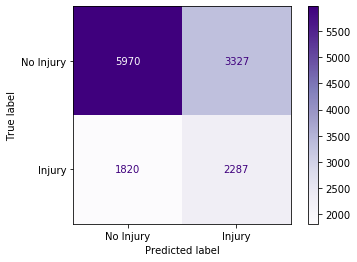

In [14]:
cm = confusion_matrix(y_validate, y_pred)
target_names = ['No Injury', 'Injury']
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp = disp.plot(cmap='Purples', values_format='.0f')
plt.show()

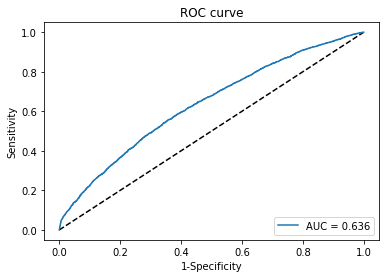

In [15]:
# Plotting ROC
fpr, tpr, thresholds = roc_curve(y_validate, y_pred_prob)
auc = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc='lower right')
# plt.savefig('/deepcovidxr/Ramsey_Keras/Resnet.pdf')
plt.show()

## Running Best Model on Testing Data
Best model = Random Forest

In [16]:
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=25)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
y_pred_prob = rfc.predict_proba(X_test)[:,1]

In [17]:
# Printing Classification Report
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
youden_values = list(tpr - fpr)
youden_index = youden_values.index(max(youden_values))
optimal_threshold = thresholds[youden_index]
trans = np.vectorize(lambda x: 1 if x > optimal_threshold else 0)
y_pred =  trans(y_pred_prob)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.66      0.72      9329
         1.0       0.43      0.59      0.50      4075

    accuracy                           0.64     13404
   macro avg       0.61      0.62      0.61     13404
weighted avg       0.68      0.64      0.65     13404



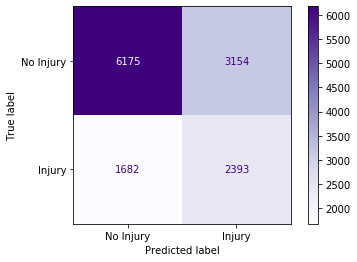

In [18]:
# Printing Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
target_names = ['No Injury', 'Injury']
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp = disp.plot(cmap='Purples', values_format='.0f')
plt.show()

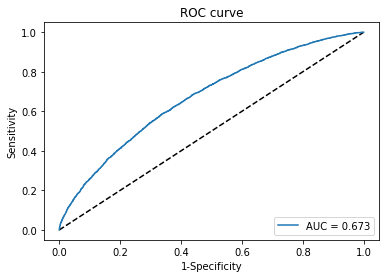

In [19]:
# Plotting ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc='lower right')
# plt.savefig('/deepcovidxr/Ramsey_Keras/Resnet.pdf')
plt.show()

Finding Feature Importance

Feature ranking:
1. subject_age (0.128513)
2. officer_age (0.122749)
3. subject_gender_M (0.027478)
4. indoor_or_outdoor_Outdoor (0.027365)
5. officer_in_uniform (0.024805)
6. wep_taser (0.023556)
7. lighting_condition_GOOD ARTIFICIAL (0.022805)
8. wep_phys (0.022367)
9. officer_injured (0.021625)
10. lighting_condition_DAYLIGHT (0.021426)
11. officer_race_White (0.021280)
12. weather_condition_RAIN (0.019852)
13. lighting_condition_POOR ARTIFICIAL (0.019377)
14. officer_race_Hispanic (0.018462)
15. lighting_condition_NIGHT (0.018035)
16. wep_other (0.017987)
17. subject_armed_True (0.017632)
18. wep_member (0.017009)
19. officer_gender_M (0.016424)
20. weather_condition_SNOW (0.016335)
21. subject_race_BLACK (0.015902)
22. officer_race_Black (0.014777)
23. subject_race_HISPANIC (0.014710)
24. weather_condition_OTHER (0.013958)
25. wep_firearm (0.012452)
26. district_name_11th (0.012159)
27. lighting_condition_DUSK (0.011907)
28. wep_verb (0.011756)
29. district_name_8th (0.011591)
30.

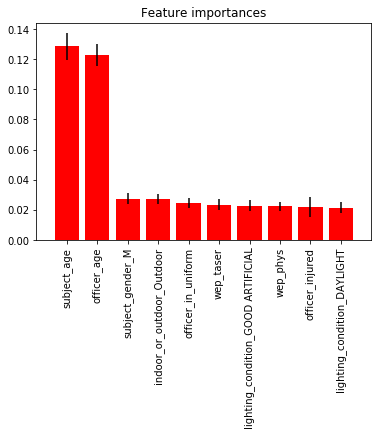

In [24]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,10), importances[indices[0:10]],
        color="r", yerr=std[indices[0:10]], align="center")
plt.xticks(range(0,10), X_train.columns[indices[0:10]], rotation = 90)
plt.xlim(-1,10)
plt.savefig("C:\\Users\\Hawkins\\Documents\\GitHub\\cpdp\\files\\Featureimportance.png", bbox_inches = "tight")
plt.show()